In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import scipy
import matplotlib.pyplot as plt
import itertools
import qinfer as qi
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from lfig import LatexFigure

sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline

In [60]:
run_path = "Dec_10/14_40"
run_path = "Dec_11/20_26"

results = qmla.load_results(
    results_folder = "/home/bf16951/bc_results/",
    results_time = run_path,
    instance_id=6, 
)
q = results['qmla_instance']
es = results['exploration_strategy']

ratings = es.ratings_class.ratings_df

def get_model_f(mid):
    return q.model_f_scores[mid]

ratings['f_score_a'] = ratings['model_a'].apply(get_model_f)
ratings['f_score_b'] = ratings['model_b'].apply(get_model_f)

In [61]:
# def offline_plot_rating_progress_single_model_static(
# ratings_df, 
# target_model_id, 
# return_df=False, 
# return_lf=None, 
# save_to_file=None
# ):

ratings_df = ratings
# target_model_id = 7 # for Dec_10/14_40
# target_model_id = q.true_model_id # for Dec_10/16_12
target_model_id = q.champion_model_id

# First isolate the ratings for this model
model_identifiers = ["a", "b"]
ratings_of_single_model = pd.DataFrame(
    columns=[
        'target', 'opponent', 
        'initial_rating_target', 'initial_rating_opponent', 
        'f_score_target', 'f_score_opponent', 
        'delta_r_target', 'final_rating_target',
        'idx', 
        'bayes_factor', 'generation', 'weight'
    ]
)
for target in model_identifiers:
    opponent = list(set(model_identifiers) - set(target))[0]

    target_ratings = ratings_df[
        ratings_df['model_{}'.format(target)] == target_model_id
        ][[
            'model_{}'.format(target),
            'model_{}'.format(opponent),
            'r_{}_initial'.format(target),
            'r_{}_initial'.format(opponent),
            'f_score_{}'.format(target), 
            'f_score_{}'.format(opponent),
            'delta_r_{}'.format(target),
            'r_{}_new'.format(target),
            'idx',
            'bayes_factor',
            'generation', 
            'weight',
            'winner'
        ]
    ]

    target_ratings.rename(
        columns={
            'model_{}'.format(target) : 'target', 
            'model_{}'.format(opponent) : 'opponent', 
            'r_{}_initial'.format(target) : 'initial_rating_target',
            'r_{}_initial'.format(opponent) : 'initial_rating_opponent', 
            'f_score_{}'.format(target) : 'f_score_target', 
            'f_score_{}'.format(opponent) : 'f_score_opponent',
            'r_{}_new'.format(target) : 'final_rating_target',
            'delta_r_{}'.format(target) : 'delta_r_target'
        }, 
        inplace=True
    )

    ratings_of_single_model = ratings_of_single_model.append(target_ratings, ignore_index=True)

ratings_of_single_model['won_comparison'] = (ratings_of_single_model.winner == ratings_of_single_model.target)
ratings_of_single_model.won_comparison.replace({True: "Won", False : "Lost"}, inplace=True)
ratings_of_single_model.sort_values('idx', inplace=True)
ratings_of_single_model['new_idx'] = list(range(len(ratings_of_single_model)))

# Plot 3 perspectives on this data:
# 1. How rating changes
# 2. relative change per comparison
# 3. strength of evidence each comparison

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


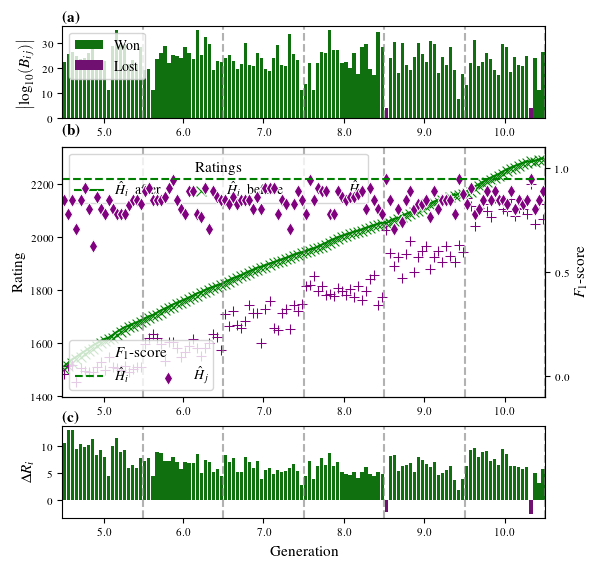

In [62]:
plots_to_include = [
    "ratings_progress", 
    "delta_r", 
    "bf"
]
include_f_ax = True

lf = LatexFigure(
    fraction=0.9, 
    use_gridspec=True, 
    gridspec_layout=(len(plots_to_include),1),
    gridspec_params = {
        'height_ratios' : [0.35, 0.95, 0.35]
    }
)

if "bf" in plots_to_include:
    
    # Bayes factor comparisons
    ax2 = lf.new_axis()
    sns.barplot(
        data = ratings_of_single_model, 
        y = 'weight', 
        x = 'new_idx',
        hue='won_comparison',
        palette = {"Won" : "green", "Lost" : "purple"},
        dodge=False, 
        ax = ax2
    )
    ax2.legend(title=None, loc="upper left")
    ax2.set_ylabel(r"$\left| \log_{10}(B_{ij}) \right|$")

    generations = ratings_of_single_model.generation.unique()
    generation_change_indices = {
        g : ratings_of_single_model[
            ratings_of_single_model.generation == g].new_idx.max() + 0.5
        for g in generations
    }


# Actual ratings
if "ratings_progress" in plots_to_include:
    ax0 = lf.new_axis(
        ax_params = {'sharex' : ax2}
    )
    sns.scatterplot(
        data = ratings_of_single_model, 
        x = 'new_idx', 
        y = 'initial_rating_target',
        label=r"$\hat{H}_i$ \ before",
        color='green',
        marker='x', 
        s = 50,
        ax = ax0,
    )

    sns.lineplot(
        data = ratings_of_single_model, 
        x = 'new_idx', 
        y = 'final_rating_target', 
        label=r"$\hat{H}_i$ \ after",
        color = 'green', 
        ax = ax0
    )

    sns.scatterplot(
        x = 'new_idx', 
        y = 'initial_rating_opponent',
        data = ratings_of_single_model, 
        label=r"$\hat{H}_j$", 
        color = 'purple',
        marker = '+',
        s = 50, 
        ax = ax0, 
    )
    ax0.legend()
    ax0.set_ylabel('Rating')
    ax0.set_xticks([])
    ax0.set_xlabel("")
    ax0.legend(title="Ratings", loc="upper left", ncol=3)

if include_f_ax:
    f_score_ax = ax0.twinx()
    sns.scatterplot(
        x = 'new_idx', 
        y = 'f_score_opponent',
        data = ratings_of_single_model, 
        label = r"$\hat{H}_j$",
        marker = 'd',
        s = 50, 
        color = 'purple',
        ax = f_score_ax, 
    )
    target_f_score = ratings_of_single_model.f_score_target.values[0]
    f_score_ax.axhline(
        target_f_score, 
        color = 'green', 
        ls = '--', 
        label = r"$\hat{H}_i$",
    )
    f_score_ax.set_ylabel(r"$F_1$-score")

    f_score_ax.legend(
        title=r"$F_1$-score",
        loc="lower left",
        ncol=2
    )
    f_score_ax.set_ylim(-0.1,1.1)
    f_score_ax.set_yticks([0, 0.5, 1])    


if "delta_r" in plots_to_include:
    ax1 = lf.new_axis(
        ax_params = {'sharex' : ax2}
    )
    sns.barplot(
        data = ratings_of_single_model, 
        y = 'delta_r_target', 
        x = 'new_idx',
        hue='won_comparison',
        palette = {"Won" : "green", "Lost" : "purple"},
        dodge=False, 
        ax = ax1
    )
    ax1.set_ylabel(r"$\Delta R_i$")
    ax1.set_xticks([])
    ax1.set_xlabel("")
    ax1.get_legend().remove()




for ax in lf.gridspec_axes.values():
    ax.set_xlabel("")
    ax.set_xticks([])

bottom_ax = lf.gridspec_axes[(lf.num_rows-1, 0)]
if len(generations) > 1:
    # vertical lines separating generations
    for ax in lf.gridspec_axes.values():
        for g in generation_change_indices.values():
            ax.axvline(g,ls='--', c='grey', alpha=0.6, )

    # label x-axis with generations
    xtick_locations = [generation_change_indices[g] for g in generations]
    xtick_locations.insert(0,0)
    centred_xticks = [ 
        np.mean([xtick_locations[i], xtick_locations[i+1] ]) 
        for i in range(len(xtick_locations)-1) 
    ]

    
    bottom_ax.set_xticklabels(generations)
    bottom_ax.set_xticks(centred_xticks)
    bottom_ax.set_xlabel("Generation")
else:
    bottom_ax.set_xticks(
        range(len(ratings_of_single_model['new_idx'])),
    )
    bottom_ax.set_xticklabels(
        range(1, 1+len(ratings_of_single_model['new_idx']))
    )
    bottom_ax.set_xlabel("Comparison")

# lf.save(
#     os.path.join(
#         "/home/bf16951/thesis/theoretical_study/figures", 
#         "single_generation_ratings_progression.pdf"
#     )
# )

In [63]:
ga = es.genetic_algorithm

In [64]:
ga.elite_models[
    ["generation", "f_score", "elite_position"]
]

,generation,f_score,elite_position
0,1,0.736842,1
1,1,0.600000,2
2,2,0.736842,1
3,2,0.777778,2
4,3,0.800000,1
5,3,0.842105,2
6,4,0.800000,1
7,4,0.842105,2
8,5,0.888889,1
9,5,0.842105,2


In [65]:
q.true_model_id

353

In [66]:
es.ratings_class.get_ratings([q.champion_model_id, q.true_model_id])

{266.0: 2297.33, 353: 2289.28}

In [68]:
es.ratings_class.all_ratings[
    (es.ratings_class.all_ratings.model_id  == q.champion_model_id)
]

,generation,idx,model_id,rating
6310,5.0,0.0,266.0,1501.77
6413,5.0,1.0,266.0,1512.32
6667,5.0,2.0,266.0,1525.23
6694,5.0,3.0,266.0,1538.25
6799,5.0,4.0,266.0,1547.67
6855,5.0,5.0,266.0,1558.04
6856,5.0,6.0,266.0,1567.81
6859,5.0,7.0,266.0,1578.03
6860,5.0,8.0,266.0,1589.42
6863,5.0,9.0,266.0,1597.85


In [69]:
es.ratings_class.all_ratings[
    (es.ratings_class.all_ratings.model_id == q.true_model_id)
]

,generation,idx,model_id,rating
12636,10.0,0.0,353.0,2108.16
12700,10.0,1.0,353.0,2120.46
12738,10.0,2.0,353.0,2129.76
12741,10.0,3.0,353.0,2141.82
12743,10.0,4.0,353.0,2155.71
12745,10.0,5.0,353.0,2166.86
12746,10.0,6.0,353.0,2177.54
12748,10.0,7.0,353.0,2184.58
12750,10.0,8.0,353.0,2192.73
12753,10.0,9.0,353.0,2201.00
